This notebook will perform interaction regression on the set of PRS to predict general breast cancer. 

In [1]:
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from functools import reduce
from itertools import product,combinations
from scipy.special import binom
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_validate

Let's set a working directory.

In [2]:
wd = '.'
os.chdir(wd)

Let <tt>`df_path`</tt> be the name of a tab-delimited data file (with header) containing the following columns: 
* ID: individual level identifiers
* ER+: PRS for ER+
* ER-: PRS for ER-
* TPN: PRS for triple-negative
* Unknown: PRS for unknown subtype
* Outcome: Case/control status

In [3]:
df_path = 'example_prs.txt'
predictors = ['ER+','ER-','TPN','Unknown']

df = pd.read_csv(df_path,sep='\t')
full_X = df[predictors]
y = df['Outcome']
df

,ID,ER+,ER-,TPN,Unknown,Outcome
0,1,3.913176,4.789395,3.768635,4.267594,0
1,2,5.437526,4.961258,5.345281,5.348923,1
2,3,3.441627,3.675188,3.419332,5.019436,0
3,4,4.591922,5.578862,4.208410,4.131067,1
4,5,4.848332,5.020004,3.590077,4.633821,0
...,...,...,...,...,...,...
99995,99996,5.361359,2.361570,5.072081,2.292960,1
99996,99997,4.101799,4.987652,3.769553,4.006571,1
99997,99998,2.279556,7.329294,4.785082,4.548452,0
99998,99999,4.005233,3.773939,4.227683,3.423258,0


We'll need test data for the boundary problem later, say, 20% of the full data.

In [4]:
test_prop = 0.2
full_X,test_X,y,test_y = train_test_split(full_X,y,test_size=test_prop)

We'll test every combination of subtype PRS. This code produces the powerset of the set of subtypes.

In [5]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(1,len(s)+1))

subsets = list(powerset(predictors))
subsets

[('ER+',),
 ('ER-',),
 ('TPN',),
 ('Unknown',),
 ('ER+', 'ER-'),
 ('ER+', 'TPN'),
 ('ER+', 'Unknown'),
 ('ER-', 'TPN'),
 ('ER-', 'Unknown'),
 ('TPN', 'Unknown'),
 ('ER+', 'ER-', 'TPN'),
 ('ER+', 'ER-', 'Unknown'),
 ('ER+', 'TPN', 'Unknown'),
 ('ER-', 'TPN', 'Unknown'),
 ('ER+', 'ER-', 'TPN', 'Unknown')]

For each subset of the PRS, we'll fit a model with the subset and all pairwise interactions within the subset as predictors. To determine model fit, we'll use 5-fold CV and take the mean AUC together with the standard deviation in AUC. 

In [6]:
accuracies = []
models = []
nfolds = 5
for s in subsets:
    s = list(s)
    X = full_X[s]
    X.insert(0,'Intercept',np.ones(X.shape[0]))
    marginal_X = X.copy(deep=True)
    pairs = list(combinations(s,2))
    columns = ['x'.join(p) for p in pairs]

    # Compute the pairwise products of all subtypes in the subset
    X[columns] = pd.DataFrame([X[a]*X[b] for a,b in pairs]).T

    # We'll use the L2 penalty
    # First, fit the model with interactions
    lr = LogisticRegression(penalty='l2',C=1,max_iter=10**4)
    results = cross_validate(lr,
                             X,
                             y,
                             cv=nfolds,
                             scoring='roc_auc',
                             return_estimator=True)
    scores = results['test_score']

    # Compute the average ROC and standard deviations across all folds
    accuracies.append([scores.mean(),scores.std()])
    lr = LogisticRegression(penalty='l2',C=1)
    lr.fit(X,y)
    models.append(lr)

    # Next, fit the model without interactions
    lr = LogisticRegression(penalty='l2',C=1,max_iter=10**4)
    results = cross_validate(lr,
                             marginal_X,
                             y,
                             cv=nfolds,
                             scoring='roc_auc',
                             return_estimator=True)
    scores = results['test_score']

    # Compute the average ROC and standard deviations across all folds
    accuracies.append([scores.mean(),scores.std()])
    lr = LogisticRegression(penalty='l2',C=1)
    lr.fit(marginal_X,y)
    models.append(lr)

/Users/jwang194/miniforge3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jwang194/miniforge3/envs/breast_cancer/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

Let's collect the accuracies and model weights. All of the model data will be in semi-lexicographic order. 

In [7]:
accuracies = np.array(accuracies)
index_order = ['Intercept',
               'ER+',
               'ER-',
               'TPN',
               'Unknown',
               'ER+xER-',
               'ER+xTPN',
               'ER-xTPN',
               'ER+xUnknown',
               'ER-xUnknown',
               'TPNxUnknown']

index_dict = {s:i for s,i in zip(index_order,range(len(index_order)))}

# The weight matrix is of dimension (2^#predictors-1, #predictors + (#predictors choose 2))
weights = np.zeros((2*(2**len(predictors)-1),len(index_order)))
repeated_subsets = reduce(lambda x,y: x+y,[[s,s] for s in subsets])
for i,s,m in zip(range(2*len(subsets)),repeated_subsets,models):
    pairs = ['x'.join(p) for p in combinations(s,2)]
    variables = ['Intercept'] + list(s) + pairs
    if m.coef_[0].shape[0] < len(index_order):
        m.coef_[0] = list(m.coef_[0]) + [0]*(m.coef_[0].shape[0] - len(index_order))
    for w,v in zip(m.coef_[0],variables):
        weights[i,index_dict[v]] = w

output = np.hstack((accuracies,weights))
output = pd.DataFrame(output,columns = ['Mean AUC','Standard Deviation of AUC'] + index_order)
output.index = reduce(lambda x,y: x+y, [[', '.join(list(s)), 'Marginal '+', '.join(list(s))] for s in subsets])
output

,Mean AUC,Standard Deviation of AUC,Intercept,ER+,ER-,TPN,Unknown,ER+xER-,ER+xTPN,ER-xTPN,ER+xUnknown,ER-xUnknown,TPNxUnknown
ER+,0.843538,0.003610,-3.636669,1.741761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Marginal ER+,0.843538,0.003610,-3.636669,1.741761,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ER-,0.659594,0.005758,-1.483397,0.000000,0.597933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Marginal ER-,0.659594,0.005758,-1.483397,0.000000,0.597933,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TPN,0.668305,0.003441,-1.266873,0.000000,0.000000,0.629248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Marginal TPN,0.668305,0.003441,-1.266873,0.000000,0.000000,0.629248,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Unknown,0.508232,0.004327,0.045568,0.000000,0.000000,0.000000,-0.030987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Marginal Unknown,0.508232,0.004327,0.045568,0.000000,0.000000,0.000000,-0.030987,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
"ER+, ER-",0.883783,0.002676,-4.940380,1.222737,0.287485,0.000000,0.000000,0.168100,0.000000,0.000000,0.000000,0.000000,0.000000
"Marginal ER+, ER-",0.884828,0.002791,-6.657959,2.034541,0.983919,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Let <tt>`odir`</tt> be the output path for the accuracies and weights.

In [8]:
odir = 'example_models.txt'
output.to_csv(odir,sep='\t',index=False)

Now that we have fitted models, we can produce:
1. Per-SNP and per-SNP-pair odds ratios
2. Decision boundaries 

Part I: Per-SNP and per-SNP-pair odds ratios

Note that this can be quite memory- and time-intensive since we have a quadratic number of SNP-pairs. I include an option to restrict the joint PRS to SNPs only, but this will decrease performance proportionally to the coefficients of the interaction terms. 

In [9]:
include_pairs = True

Let this be a path to a tab-delimited file (with header and index) containing:
* One column for each SNP
* One row for for each subtype PRS
* In each entry, effect sizes (log-odds ratios) for the corresponding SNP-PRS pair

In [10]:
snp_dir = 'example_betas.txt'
snps = pd.read_csv(snp_dir,sep='\t',index_col=0)
M = snps.shape[1]
flatten_indices = np.triu_indices(M)
snps

,SNP0,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,...,SNP9990,SNP9991,SNP9992,SNP9993,SNP9994,SNP9995,SNP9996,SNP9997,SNP9998,SNP9999
ER+,1.557021,-1.296979,0.545391,2.544733,-0.275538,-1.114323,-0.510874,-1.602284,-0.585997,0.041780,...,-0.532322,-0.139649,-0.590772,-1.290361,1.522291,-0.658281,0.428884,0.103424,-1.093268,1.097769
ER-,0.481885,0.464024,2.389046,-0.978093,-1.346064,-0.395001,-0.694183,1.712516,0.216843,0.549836,...,0.638654,1.721985,0.545479,2.145569,-1.946853,-0.315197,1.097832,-1.430939,0.688392,0.811173
TPN,-0.428238,-0.639179,-0.110459,-0.794221,1.056234,-1.101707,-1.318918,-0.179981,-0.542706,-0.401308,...,0.171558,1.911572,0.184262,-0.646846,-1.424846,-0.545879,-0.944465,0.556771,-1.895351,-0.230970
Unknown,0.432864,-0.859334,-0.317044,1.880684,0.799748,0.656739,0.328446,0.858674,0.031187,-0.109298,...,1.158993,-0.450603,-0.088951,-0.427817,-0.993111,-0.378676,0.409084,0.753360,1.698159,-0.333793


The following code computes the coefficients of each SNP-pair on each pair of PRS, if pairs are included above. This may make it quite slow, depending on the number of SNPs included. On an Intel Gold 61 processor or on an Apple M2 processor, this takes around five minutes for 10^4 SNPs. For the same number of SNPs, ~18GB RAM is sufficient.

In [11]:
prs_pairs = ['x'.join(p) for p in combinations(snps.index,2)]
snp_pairs = np.char.add(np.char.add(np.array(snps.columns)[:, np.newaxis], "x"), np.array(snps.columns))
snp_pairs = snp_pairs[flatten_indices]
# Compute a matrix of SNP-pair effects for each product of PRSs then merge effect matrices...
if include_pairs:
    pairs = pd.DataFrame(np.zeros((len(prs_pairs),len(snp_pairs))))
    pairs = pd.DataFrame(np.zeros((len(prs_pairs),len(snp_pairs))))
    pairs.index = prs_pairs
    pairs.columns = snp_pairs
    for pp in prs_pairs:
        prs1,prs2 = pp.split('x')
        pairs.loc[pp] = np.outer(snps.loc[prs1],snps.loc[prs2])[flatten_indices]
    # Collect SNP-pair and single-SNP effects into block matrix form
    A = np.block([
            [snps,                       np.zeros((snps.shape[0],pairs.shape[1]))],
            [np.zeros((pairs.shape[0],snps.shape[1])),                      pairs]
    ])
    snp_weights = pd.DataFrame(A)
    snp_weights.index = list(snps.index) + list(pairs.index)
    snp_weights.columns = list(snps.columns) + list(pairs.columns)
# ...Or simply use single-SNP effects
else:
    snp_weights = snps

snp_weights

,SNP0,SNP1,SNP2,SNP3,SNP4,SNP5,SNP6,SNP7,SNP8,SNP9,...,SNP9996xSNP9996,SNP9996xSNP9997,SNP9996xSNP9998,SNP9996xSNP9999,SNP9997xSNP9997,SNP9997xSNP9998,SNP9997xSNP9999,SNP9998xSNP9998,SNP9998xSNP9999,SNP9999xSNP9999
ER+,1.557021,-1.296979,0.545391,2.544733,-0.275538,-1.114323,-0.510874,-1.602284,-0.585997,0.041780,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ER-,0.481885,0.464024,2.389046,-0.978093,-1.346064,-0.395001,-0.694183,1.712516,0.216843,0.549836,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TPN,-0.428238,-0.639179,-0.110459,-0.794221,1.056234,-1.101707,-1.318918,-0.179981,-0.542706,-0.401308,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Unknown,0.432864,-0.859334,-0.317044,1.880684,0.799748,0.656739,0.328446,0.858674,0.031187,-0.109298,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ER+xER-,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.470843,-0.613707,0.295241,0.347899,-0.147993,0.071196,0.083895,-0.752597,-0.886829,0.890481
ER+xTPN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.405066,0.238790,-0.812886,-0.099059,0.057583,-0.196024,-0.023888,2.072126,0.252512,-0.253552
ER+xUnknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.175450,0.323104,0.728314,-0.143159,0.077915,0.175630,-0.034522,-1.856542,0.364925,-0.366428
ER-xTPN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.036864,0.611241,-2.080776,-0.253566,-0.796705,2.712131,0.330504,-1.304745,-0.158998,-0.187357
ER-xUnknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.449106,0.827063,1.864293,-0.366449,-1.078012,-2.429961,0.477638,1.169000,-0.229781,-0.270764
TPNxUnknown,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.386366,-0.711522,-1.603851,0.315256,0.419449,0.945486,-0.185846,-3.218607,0.632655,0.077096


This function will compute effect sizes (log-odds ratios) for each SNP on a single ensemble PRS. It uses the trivial application of distributivity to $$\alpha_1(\sum \beta_{1,i} x_i) + \alpha_2(\sum \beta_{2,i} x_i) + \alpha_3(\sum \sum \beta_{1,i} \beta_{2,j} x_i x_j)$$

In [12]:
def distribute_coefficients(weights):
    if include_pairs:
        return snp_weights.T @ weights
    else:
        return snp_weights.T @ weights[:len(predictors)]

distribute_coefficients(output.loc['ER+, ER-'][output.columns[3:]])

SNP0               2.042363
SNP1              -1.452465
SNP2               1.353685
SNP3               2.830353
SNP4              -0.723885
                     ...   
SNP9997xSNP9998    0.011968
SNP9997xSNP9999    0.014103
SNP9998xSNP9998   -0.126511
SNP9998xSNP9999   -0.149076
SNP9999xSNP9999    0.149689
Length: 50015000, dtype: float64

Part II: Decision boundaries

Recall that test_X and test_y were pulled from the data above.

In [13]:
expanded_X = test_X.copy(deep=True)
for i in index_order[1:]:
    expanded_X[i] = reduce(lambda x,y: x*y,[expanded_X[c] for c in i.split('x')])

expanded_X.insert(0,'Intercept',np.ones(expanded_X.shape[0]))
expanded_X

,Intercept,ER+,ER-,TPN,Unknown,ER+xER-,ER+xTPN,ER-xTPN,ER+xUnknown,ER-xUnknown,TPNxUnknown
80585,1.0,4.793012,4.760337,3.429283,4.379731,22.816350,16.436591,16.324540,20.992103,20.848995,15.019335
66812,1.0,4.946868,4.160573,3.270065,4.811247,20.581806,16.176578,13.605344,23.800605,20.017546,15.733090
16009,1.0,5.549400,5.032951,4.254023,3.670949,27.929856,23.607274,21.410287,20.371566,18.475708,15.616303
22426,1.0,5.125270,4.202130,3.965881,3.262174,21.537051,20.326210,16.665145,16.719527,13.708080,12.937394
47721,1.0,3.895334,4.670104,3.329070,5.212575,18.191617,12.967842,15.547107,20.304722,24.343271,17.353030
...,...,...,...,...,...,...,...,...,...,...,...
87300,1.0,3.204189,4.280968,2.825432,6.102158,13.717028,9.053219,12.095584,19.552466,26.123140,17.241234
94303,1.0,5.149310,3.336197,4.097301,3.478004,17.179116,21.098276,13.669406,17.909321,11.603307,14.250430
83385,1.0,3.467308,4.063158,3.237629,4.653109,14.088221,11.225857,13.154995,16.133764,18.906316,15.065039
42892,1.0,5.036799,6.074485,3.608148,3.930924,30.595962,18.173514,21.917640,19.799274,23.878340,14.183354


This function will determine the constant for the appropriate level set for one set of weights.

In [14]:
def boundary(weights,percent):
    # Compute the correct level set to select top percent% of individuals
    scores = expanded_X @ weights
    level_set = np.quantile(scores,1-percent)
    return level_set 

# Let's try this with the ER+ and ER- subset
threshold = boundary(output.loc['ER+, ER-'][output.columns[2:]],0.1)
threshold

np.float64(7.840535961874858)

We can also visualize some contours for pairs of PRS. The following pairs of functions will plot, on the space of a pair of PRS, cases in red and controls in blue, together with contours defined by a set of weights. The contours plotted will be a small distance around the threshold computed in the previous cell.

In [15]:
import matplotlib.pyplot as plt

def prs_func(weights,indices,inputs):
    expanded_points = pd.DataFrame(np.zeros((inputs.shape[0],len(predictors))))
    expanded_points.insert(0,'-1',1)
    expanded_points.iloc[:,indices] = inputs
    expanded_points.columns = ['Intercept'] + predictors
    for i in index_order[1:]:
        expanded_points[i] = reduce(lambda x,y: x*y,[expanded_points[c] for c in i.split('x')])
    return np.array(expanded_points @ weights)
    
# This function will compute levels for a given set of weights
def levels(weights,indices,eval_points):
    n_points = int(np.sqrt(eval_points.shape[0]))
    values = prs_func(weights,indices,eval_points)
    return values.reshape(n_points,n_points)

def plot_contours(P1,P2,indices,weights,threshold,cases,controls):
    A = expanded_X[P1]
    B = expanded_X[P2]
    x_ = np.linspace(A.min(),A.max(),num=40)
    y_ = np.linspace(B.min(),B.max(),num=40)
    x,y = [a.flatten() for a in np.meshgrid(x_,y_)]
    eval_points = np.hstack((x[:,None],y[:,None]))

    z = levels(weights,indices,eval_points)

    figs,axs = plt.subplots(nrows=1,ncols=2,sharey=True)
    axs[0].contour(x_,y_,z,levels=np.linspace(threshold-1,threshold+1,10))
    axs[0].scatter(x=A.loc[cases],y=B.loc[cases],c='r',alpha=0.1)
    axs[1].contour(x_,y_,z,levels=np.linspace(threshold-1,threshold+1,10))
    axs[0].set_xlabel(P1)
    axs[1].set_xlabel(P1)
    axs[0].set_ylabel(P2)
    cont = axs[1].scatter(x=A.loc[controls],y=B.loc[controls],c='b',alpha=0.1)
    figs.colorbar(cont,ax=axs,values=np.linspace(threshold-1,threshold+1,10))
    plt.show()


Let's compare the case where we use ER+, ER-, and their interaction against the case where we use only ER+ and ER-.

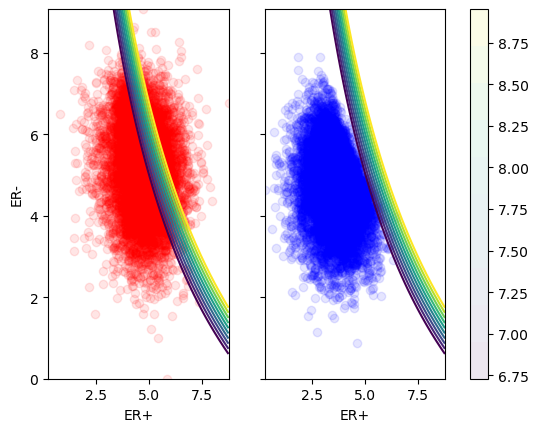

In [16]:
# First, including the interaction:
weights = output.loc['ER+, ER-'][output.columns[2:]]
plot_contours('ER+','ER-',[1,2],weights,boundary(weights,0.1),test_y == 1,test_y == 0)

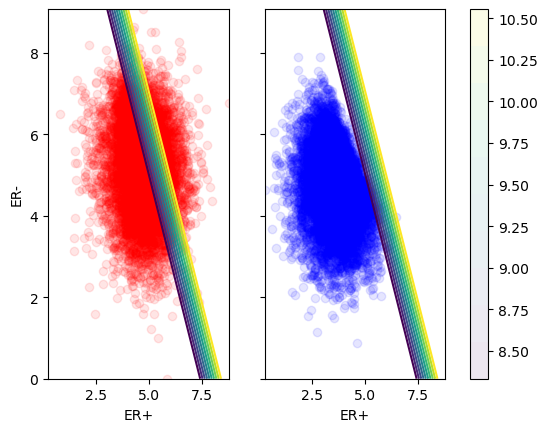

In [17]:
# Now, excluding the interaction:
weights = output.loc['Marginal ER+, ER-'][output.columns[2:]]

plot_contours('ER+','ER-',[1,2],weights,boundary(weights,0.1),test_y == 1,test_y == 0)

Now, let's compare the metric that Noah proposed: fraction of cases in the top 10% of women based on this new score i.e. the precision of the classifier defined by the boundary contour.

In [18]:
def recall(P,indices,weights,threshold,case_status):
    inputs = expanded_X[P]
    values = prs_func(weights,indices,inputs)
    thresholded_cases = case_status.loc[values>threshold]
    return thresholded_cases.sum()/thresholded_cases.shape[0]

interaction_weights = output.loc['ER+, ER-'][output.columns[2:]]
marginal_weights = output.loc['Marginal ER+, ER-'][output.columns[2:]]
print('interaction recall: %s'%recall(['ER+','ER-'],[1,2],interaction_weights,boundary(interaction_weights,0.1),test_y))
print('marginal recall: %s'%recall(['ER+','ER-'],[1,2],marginal_weights,boundary(marginal_weights,0.1),test_y))

interaction recall: 0.9995
marginal recall: 0.999


Maybe another metric as well: the sensitivity of this classifier.

In [19]:
def sensitivity(P,indices,weights,threshold,case_status):
    inputs = expanded_X[P]
    values = prs_func(weights,indices,inputs)
    thresholded_cases = case_status.loc[values>threshold]
    return thresholded_cases.sum()/case_status.sum()

print('interaction sensitivity: %s'%sensitivity(['ER+','ER-'],[1,2],interaction_weights,boundary(interaction_weights,0.1),test_y))
print('marginal sensitivity: %s'%sensitivity(['ER+','ER-'],[1,2],marginal_weights,boundary(marginal_weights,0.1),test_y))

interaction sensitivity: 0.20489954899548996
marginal sensitivity: 0.2047970479704797


When the underlying generative model for case-control status depends on several PRS, including interactions for any particular pair seems unlikely to dramatically improve performance. 